In [16]:
# load libraries and scripts
import JSON
using Plots
using HDF5
using Trapz
using Statistics
using SparseArrays
using LinearAlgebra
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/disturbances.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/vectorize.jl")

vectorize_ref (generic function with 1 method)

In [2]:
#load borders
border = import_border("../data/borders/border.json");

In [3]:
# create the lattice grid
dx = 20.0
Nx, Ny, xrange, yrange, isinside, isborder, n, isgrid = get_grid(border, Float64(dx));

In [4]:
m = 1e-5 * ones(Ny, Nx)
d = 0.3 * m
bx = 8 * ones(Ny, Nx)
by = 8 * ones(Ny, Nx)
p = zeros(Ny, Nx)
m[.!isgrid] .= 0
d[.!isgrid] .= 0
p[.!isgrid] .= 0;

In [5]:
isinsideflat, pflat, minvflat, gammaflat, xi = vectorize(isinside, isborder, n, bx, by, p, m, d);

In [6]:
isgridflat = vec(isinside .| isborder);

Synchronized frequency: -0.846119133574006


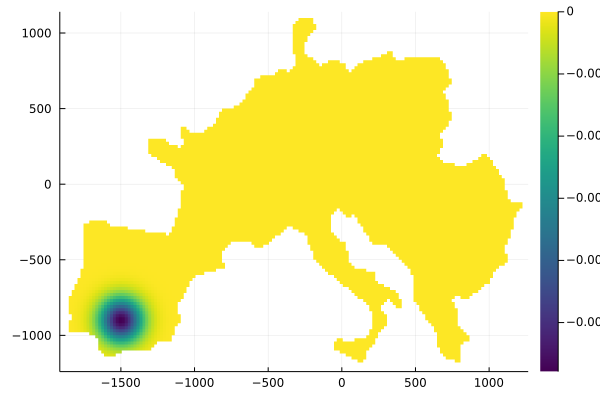

In [7]:
# define a disturbance
dP = -9.0
# dP = 0.0
sigma = 100.0
location = [-1500.0, -900.0]
dp = local_disturbance(isgrid, xrange, yrange, location, dP, sigma)
dpflat = vec(dp)
println("Synchronized frequency: ", trapz((yrange, xrange), p .+ dp) / trapz((yrange, xrange), d))
hm_plot(isinside, xrange, yrange, dp)


In [8]:
th0 = zeros(Ny*Nx)
ts_be, ~, omegas_be = perform_dyn_sim_vec_backward_euler(isgridflat, xi, pflat[isgridflat]+dpflat[isgridflat],
    minvflat, gammaflat, th0, interval = 5, Ndt = 2500, dt = 0.01)
ts_cn, ~, omegas_cn = perform_dyn_sim_vec_crank_nicolson(isgridflat, xi, pflat[isgridflat]+dpflat[isgridflat],
    minvflat, gammaflat, th0, interval = 1, Ndt = 500, dt = 0.05)
ts_v, ~, omegas_v = perform_dyn_sim_vec(isgridflat, xi, pflat[isgridflat]+dpflat[isgridflat],
    minvflat, gammaflat, th0, interval = 1000, Ndt = 250000, dt = 0.0001)
omegas_be = back_to_2d(isgrid, omegas_be)
omegas_cn = back_to_2d(isgrid, omegas_cn)
omegas_v = back_to_2d(isgrid, omegas_v)

Total time: 25.0
NIter: 5 Avg. Omega: -0.012628916934416813
NIter: 10 Avg. Omega: -0.02520557083442262
NIter: 15 Avg. Omega: -0.03778253621364985
NIter: 20 Avg. Omega: -0.050376597327355256
NIter: 25 Avg. Omega: -0.06294860176059208
NIter: 30 Avg. Omega: -0.07541084680367378
NIter: 35 Avg. Omega: -0.08765546403100398
NIter: 40 Avg. Omega: -0.09958928683485271
NIter: 45 Avg. Omega: -0.11116313385136402
NIter: 50 Avg. Omega: -0.12238527231347698
NIter: 55 Avg. Omega: -0.13331080952253407
NIter: 60 Avg. Omega: -0.14401044776330915
NIter: 65 Avg. Omega: -0.15453635191559942
NIter: 70 Avg. Omega: -0.16490481528837303
NIter: 75 Avg. Omega: -0.17510258428236328
NIter: 80 Avg. Omega: -0.1851078390101745
NIter: 85 Avg. Omega: -0.19491045522683048
NIter: 90 Avg. Omega: -0.2045211956600766
NIter: 95 Avg. Omega: -0.21396846357532495
NIter: 100 Avg. Omega: -0.22328698767855606
NIter: 105 Avg. Omega: -0.2325039323372875
NIter: 110 Avg. Omega: -0.24162705611404772
NIter: 115 Avg. Omega: -0.2506388633

NIter: 955 Avg. Omega: -0.758227788939433
NIter: 960 Avg. Omega: -0.7590415719382616
NIter: 965 Avg. Omega: -0.7598360562473494
NIter: 970 Avg. Omega: -0.7606111538393925
NIter: 975 Avg. Omega: -0.7613667914880194
NIter: 980 Avg. Omega: -0.7621028864710272
NIter: 985 Avg. Omega: -0.762819332422984
NIter: 990 Avg. Omega: -0.763515996976329
NIter: 995 Avg. Omega: -0.7641927311111313
NIter: 1000 Avg. Omega: -0.7648493884946587
NIter: 1005 Avg. Omega: -0.765485851737286
NIter: 1010 Avg. Omega: -0.766102061581614
NIter: 1015 Avg. Omega: -0.7666980446722114
NIter: 1020 Avg. Omega: -0.7672739357480199
NIter: 1025 Avg. Omega: -0.7678299908175245
NIter: 1030 Avg. Omega: -0.7683665890259789
NIter: 1035 Avg. Omega: -0.7688842223723309
NIter: 1040 Avg. Omega: -0.7693834740178683
NIter: 1045 Avg. Omega: -0.7698649874618834
NIter: 1050 Avg. Omega: -0.7703294301415056
NIter: 1055 Avg. Omega: -0.7707774558508796
NIter: 1060 Avg. Omega: -0.7712096706153991
NIter: 1065 Avg. Omega: -0.7716266062215011
NI

NIter: 1890 Avg. Omega: -0.7979535964986993
NIter: 1895 Avg. Omega: -0.7979795389382729
NIter: 1900 Avg. Omega: -0.7980037261995585
NIter: 1905 Avg. Omega: -0.7980261275484847
NIter: 1910 Avg. Omega: -0.7980467212482507
NIter: 1915 Avg. Omega: -0.7980654952213856
NIter: 1920 Avg. Omega: -0.798082447083559
NIter: 1925 Avg. Omega: -0.7980975837153288
NIter: 1930 Avg. Omega: -0.7981109205581812
NIter: 1935 Avg. Omega: -0.7981224808145903
NIter: 1940 Avg. Omega: -0.7981322947018467
NIter: 1945 Avg. Omega: -0.7981403988622593
NIter: 1950 Avg. Omega: -0.7981468359759417
NIter: 1955 Avg. Omega: -0.7981516545654254
NIter: 1960 Avg. Omega: -0.7981549089317985
NIter: 1965 Avg. Omega: -0.7981566591264244
NIter: 1970 Avg. Omega: -0.7981569708446924
NIter: 1975 Avg. Omega: -0.7981559151303249
NIter: 1980 Avg. Omega: -0.7981535677991258
NIter: 1985 Avg. Omega: -0.7981500085264479
NIter: 1990 Avg. Omega: -0.7981453195875723
NIter: 1995 Avg. Omega: -0.7981395842886893
NIter: 2000 Avg. Omega: -0.798132

NIter: 66 Avg. Omega: -0.5095483532879805
NIter: 67 Avg. Omega: -0.5133230944275495
NIter: 68 Avg. Omega: -0.5171603242018887
NIter: 69 Avg. Omega: -0.5210559792891466
NIter: 70 Avg. Omega: -0.5249835437022536
NIter: 71 Avg. Omega: -0.528902579786367
NIter: 72 Avg. Omega: -0.5327676314536101
NIter: 73 Avg. Omega: -0.5365345616549633
NIter: 74 Avg. Omega: -0.5401683951206915
NIter: 75 Avg. Omega: -0.5436546549301049
NIter: 76 Avg. Omega: -0.5470046526893055
NIter: 77 Avg. Omega: -0.5502501811666451
NIter: 78 Avg. Omega: -0.5534277529095097
NIter: 79 Avg. Omega: -0.5565639631148508
NIter: 80 Avg. Omega: -0.5596710706914934
NIter: 81 Avg. Omega: -0.5627445384348194
NIter: 82 Avg. Omega: -0.5657671127020143
NIter: 83 Avg. Omega: -0.5687249294466208
NIter: 84 Avg. Omega: -0.5716136701887669
NIter: 85 Avg. Omega: -0.574437837091044
NIter: 86 Avg. Omega: -0.5772200477531083
NIter: 87 Avg. Omega: -0.5799984237489796
NIter: 88 Avg. Omega: -0.5828121979260384
NIter: 89 Avg. Omega: -0.58569101161

NIter: 259 Avg. Omega: -0.7812296762207552
NIter: 260 Avg. Omega: -0.781349060490136
NIter: 261 Avg. Omega: -0.7814953299439695
NIter: 262 Avg. Omega: -0.7816733778980732
NIter: 263 Avg. Omega: -0.7818802860759879
NIter: 264 Avg. Omega: -0.7821095722444034
NIter: 265 Avg. Omega: -0.782348344447186
NIter: 266 Avg. Omega: -0.782581287219513
NIter: 267 Avg. Omega: -0.7827979917696959
NIter: 268 Avg. Omega: -0.7829963710263227
NIter: 269 Avg. Omega: -0.7831822257716295
NIter: 270 Avg. Omega: -0.7833619290158877
NIter: 271 Avg. Omega: -0.7835368876622085
NIter: 272 Avg. Omega: -0.783702393421852
NIter: 273 Avg. Omega: -0.7838477375010727
NIter: 274 Avg. Omega: -0.7839667190237288
NIter: 275 Avg. Omega: -0.7840671418535516
NIter: 276 Avg. Omega: -0.7841670773462124
NIter: 277 Avg. Omega: -0.7842891259177251
NIter: 278 Avg. Omega: -0.7844486235017968
NIter: 279 Avg. Omega: -0.7846431753813156
NIter: 280 Avg. Omega: -0.7848613693785963
NIter: 281 Avg. Omega: -0.7850913311800175
NIter: 282 Avg.

NIter: 451 Avg. Omega: -0.7977495872994343
NIter: 452 Avg. Omega: -0.7977861850489001
NIter: 453 Avg. Omega: -0.7978238732504969
NIter: 454 Avg. Omega: -0.797860224111934
NIter: 455 Avg. Omega: -0.7978949670350349
NIter: 456 Avg. Omega: -0.7979278261055619
NIter: 457 Avg. Omega: -0.7979578169090522
NIter: 458 Avg. Omega: -0.7979847597004419
NIter: 459 Avg. Omega: -0.7980098469095501
NIter: 460 Avg. Omega: -0.7980356279292166
NIter: 461 Avg. Omega: -0.7980647458453441
NIter: 462 Avg. Omega: -0.7980976037918041
NIter: 463 Avg. Omega: -0.7981335023277194
NIter: 464 Avg. Omega: -0.7981709042011049
NIter: 465 Avg. Omega: -0.7982058750279316
NIter: 466 Avg. Omega: -0.7982367976298852
NIter: 467 Avg. Omega: -0.7982670449276585
NIter: 468 Avg. Omega: -0.7983000085205808
NIter: 469 Avg. Omega: -0.7983370915013881
NIter: 470 Avg. Omega: -0.7983781675020877
NIter: 471 Avg. Omega: -0.7984221089809646
NIter: 472 Avg. Omega: -0.7984685590025551
NIter: 473 Avg. Omega: -0.798516586761029
NIter: 474 Av

NIter: 133000 Avg. Omega: -0.7826633749237141
NIter: 134000 Avg. Omega: -0.7830089450629771
NIter: 135000 Avg. Omega: -0.7833085484969775
NIter: 136000 Avg. Omega: -0.7835276479844724
NIter: 137000 Avg. Omega: -0.7837734084918783
NIter: 138000 Avg. Omega: -0.7841331780416515
NIter: 139000 Avg. Omega: -0.7845693144585267
NIter: 140000 Avg. Omega: -0.7850148937919139
NIter: 141000 Avg. Omega: -0.7854280513296305
NIter: 142000 Avg. Omega: -0.7858047209241809
NIter: 143000 Avg. Omega: -0.7861548946006583
NIter: 144000 Avg. Omega: -0.7864836983604011
NIter: 145000 Avg. Omega: -0.7868193517077318
NIter: 146000 Avg. Omega: -0.7871822042499262
NIter: 147000 Avg. Omega: -0.7875884228272477
NIter: 148000 Avg. Omega: -0.7880175282637463
NIter: 149000 Avg. Omega: -0.7884233916462132
NIter: 150000 Avg. Omega: -0.788808186092656
NIter: 151000 Avg. Omega: -0.7891729655315832
NIter: 152000 Avg. Omega: -0.7894954965143813
NIter: 153000 Avg. Omega: -0.7898067731828636
NIter: 154000 Avg. Omega: -0.790141

119×159×251 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  

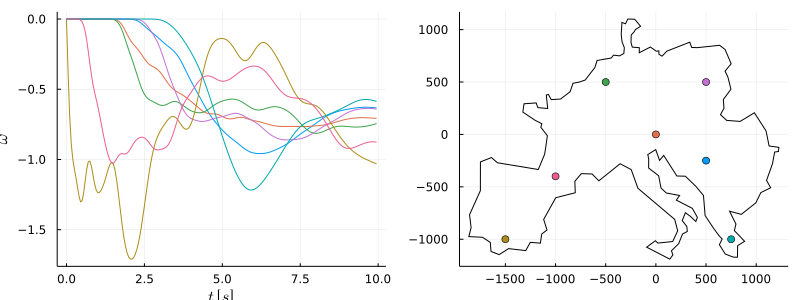

In [17]:
# backward Euler
coord = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400]
time_plot(ts_be, omegas_be, coord, tstart = 0.0, tend = 10.0, borders = [border])

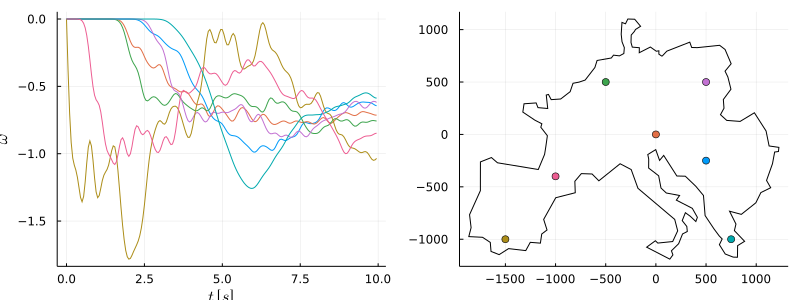

In [18]:
# Crank-Nicolson
coord = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400]
time_plot(ts_cn, omegas_cn, coord, tstart = 0.0, tend = 10.0, borders = [border])

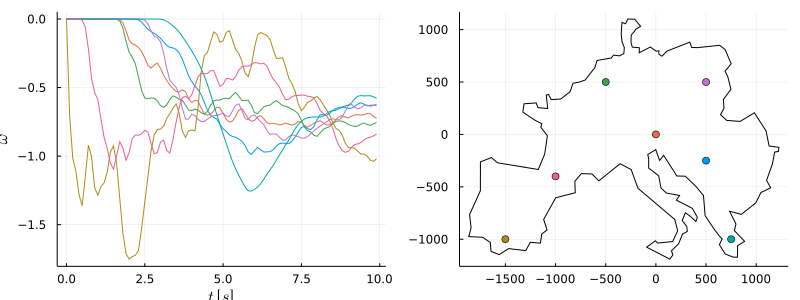

In [20]:
# "Standard vec"
coord = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400]
time_plot(ts_v, omegas_v, coord, tstart = 0.0, tend = 10.0, borders = [border])